# INTENT CLASSIFICATION AND OOS PREDICTIONS

## PROJECT WORK #1 - NLP - FEUP
### Filippo Comastri - Benedek Lellei - Amanda Oliveira 

The aim of the project is to classify queries into different intent classes. Queries are very short sentences, usually some questions or prompt commands about specific topics.

The dataset includes also out-of-scope queries. By "out-of-scope", we mean queries that do not fall into any of the system-supported intent classes. We want also to analyse how the out-of-scope queries affects the performance of the system.

## Data Analysis

In [6]:
import pandas as pd
import json
import re
import nltk
import json
import gensim
import numpy as np
import time
from matplotlib import pyplot as plt
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from operator import itemgetter
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn import preprocessing
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB


We load from the dataset the train, validation and test set and we cast them as a Pandas Dataframe. We aggregate training and validation set to have more data for training, and we keep test set to evaluate the performance of the model.

In [7]:
with open('data_full.json') as json_file: 
    data_dict = json.load(json_file) 

train_data = data_dict['train'] # Data (In scope) for traning
val_data = data_dict['val'] # Data (In scope) for validation
test_data = data_dict['test'] # Data (In scope) for test

oos_train = data_dict['oos_train'] # Data  (Out of scope)for traning 
oos_val = data_dict['oos_val'] # Data (Out of scope) for validation
oos_test = data_dict['oos_test'] # Data (Out of scope) for testing


train_df = pd.DataFrame(train_data, columns =['query', 'intent'])
val_df = pd.DataFrame(val_data, columns =['query', 'intent'])
test_df = pd.DataFrame(test_data, columns =['query', 'intent'])

# concatenating validation and train set
frames = [train_df,val_df]
train_val_df = pd.concat(frames)

train_df.head()

,query,intent
0,what expression would i use to say i love you ...,translate
1,can you tell me how to say 'i do not speak muc...,translate
2,"what is the equivalent of, 'life is good' in f...",translate
3,"tell me how to say, 'it is a beautiful morning...",translate
4,"if i were mongolian, how would i say that i am...",translate


The paper related to this dataset is from November 2018, so the genre of the corpus is modern and the language used is English.

The provided dataset contains 23,700 queries, including 22,500 in-scope queries covering 150 intents, which can be grouped into 10 general domains. For each intent, there are 100 training, 20 validation and 30 testing queries.  

The dataset also included 1,200 out-of-scope queries. Of the 1,200 out-of-scope queries collected, 100 are used for validation and 100 are used for training, leaving 1,000 for testing.

Therefore, the dataset is very balanced between in-scope intent classes. Instead, it's very unbalanced between in-scope and out-of-scope training samples because we have 15,000 in-scope queries and only 100 out-of-scope queries. But if we consider out-of-scope as an intent class we have a dataset with 151 intents and very balanced. 

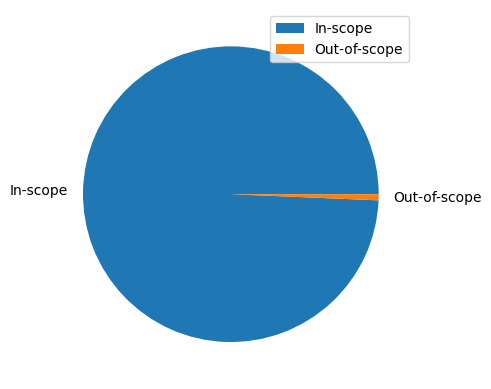

In [6]:
plt.pie([len(train_data), len(oos_train)],labels=['In-scope', 'Out-of-scope'])
plt.legend(loc='upper right')
plt.show()

The in-scope queries were collected using a scoping crowdsourcing task, which prompted crowd workers to provide questions and commands related to topic domains in the manner they would interact with an artificially intelligent assistant. Then data generated by scoping task were manually grouped into intents. 

Out-of-scope queries were collected in two ways. First, using worker mistakes: queries written for
one of the 150 intents that did not actually match any of the intents. Second, using scoping and
scenario tasks with prompts based on topic areas found on Quora, Wikipedia, and elsewhere. 

For all queries collected, all tokens were downcased, and all end-of-sentence punctuation was removed.
Additionally, all duplicate queries were removed and replaced. So the dataset is already partially pre-processed.


## Pre-Processing 
The dataset is already partially pre-processed : all words are down cased and punctuations is removed. So we just need to remove special characters and lemmatize.

We can just pass the pre-processing function as an argument to the vectorizer and then it will be applied to each word of the corpus analyzed by the vectorizer.

In [8]:
def preProcess(w):
    lemmatizer = WordNetLemmatizer()
    w = re.sub('[^a-zA-Z]', ' ', w)
    return lemmatizer.lemmatize(w)

## Word Analysis

We analyse the words in the corpus using Bag-of-Words and TF-IDF. 

When using TF-IDF we consider as document all the queries belonging to one intent class. So, we calculate the importance of each word in an intent by considering its frequency in the intent (TF) and its frequency in the entire corpus(IDF).

Meanwhile, Bag-of-Words model just considers the frequency of each word in the intent.

The following function **plot_top_n** simply uses Count Vectorizer or TF-IDF Vectorizer to count words frequencies and plots the result obtained in a bar chart together with a WordCloud.

In [15]:
def plot_top_n(corpus,keys, a_class, vectorizer, n):
    
    idx = keys.index(a_class)
    X = vectorizer.fit_transform(corpus).toarray()
    feat_val = list(zip(vectorizer.get_feature_names_out(), X[idx]))
    feat_val.sort(key=itemgetter(1), reverse=True)

    tfidf_dict = {feat: score for feat, score in zip(vectorizer.get_feature_names_out(), X[idx])}

    feat_val_top_n = feat_val[:n-1]
    feat_val_sep = list(zip(*feat_val_top_n))
    
    # only for plotting
    if type(vectorizer) == type(CountVectorizer()):
        vect = 'BAG OF WORDS'
    else :
        vect = 'TF-IDF'

    plt.figure(figsize=(10,5))
    plt.suptitle(f'{vect} - {a_class}')
    plt.subplot(1,2,1)

    if vect=='BAG OF WORDS':
        # plot's labels
        plt.xlabel("More relevant words")
        plt.ylabel("number of apperances")  
    else:
        plt.xlabel("More relevant words")
        plt.ylabel("TF-IDF SCORE")  


    # format the x values 
    plt.bar(feat_val_sep[0],feat_val_sep[1])
    plt.xticks(rotation=30, ha='right')
    if vect=='BAG OF WORDS':
        # Word Cloud
        word_list = [x for x in corpus[idx].split() if x != "ssss"]
        wordcloud = WordCloud().generate(" ".join(word_list))
        plt.subplot(1,2,2)
        plt.imshow(wordcloud)
        plt.axis('off')
        plt.show()
    else :
        wordcloud = WordCloud().generate_from_frequencies(tfidf_dict)
        plt.subplot(1,2,2)
        plt.imshow(wordcloud)
        plt.axis('off')
        plt.show()


c:\Users\comas\venvpy3107\lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['doe', 'ha', 'wa'] not in stop_words.
  warnings.warn(


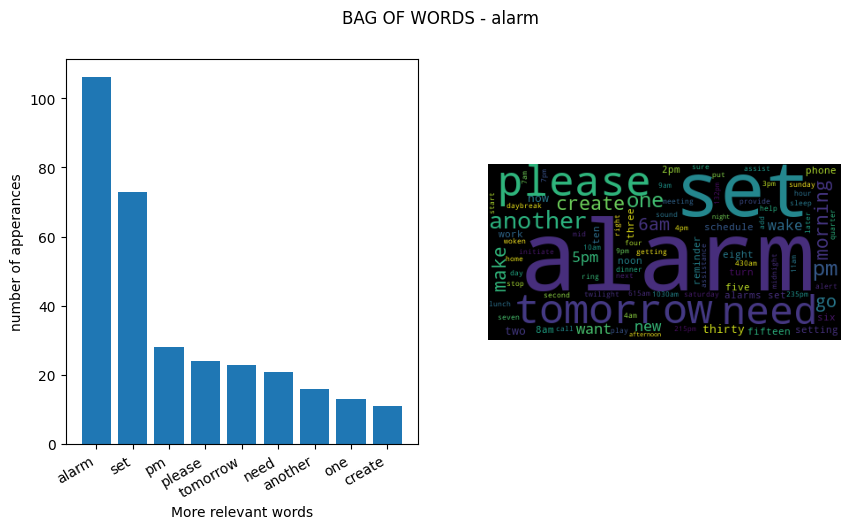

c:\Users\comas\venvpy3107\lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['doe', 'ha', 'wa'] not in stop_words.
  warnings.warn(


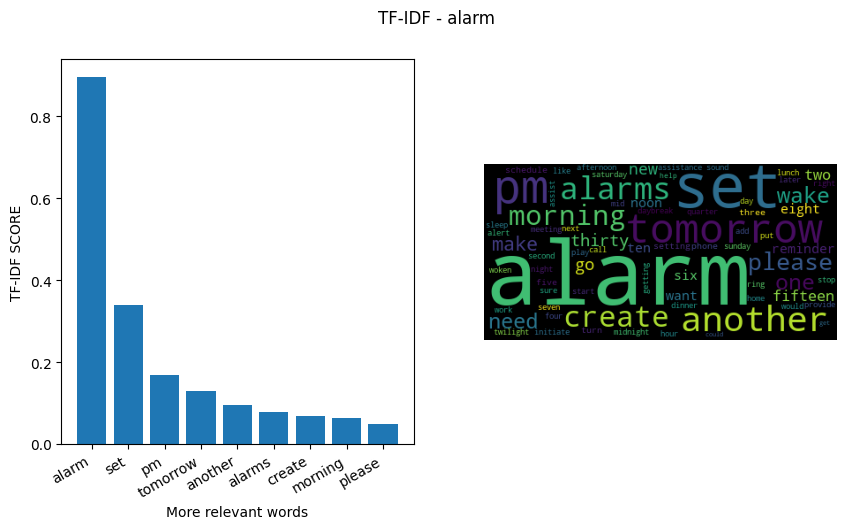

c:\Users\comas\venvpy3107\lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['doe', 'ha', 'wa'] not in stop_words.
  warnings.warn(


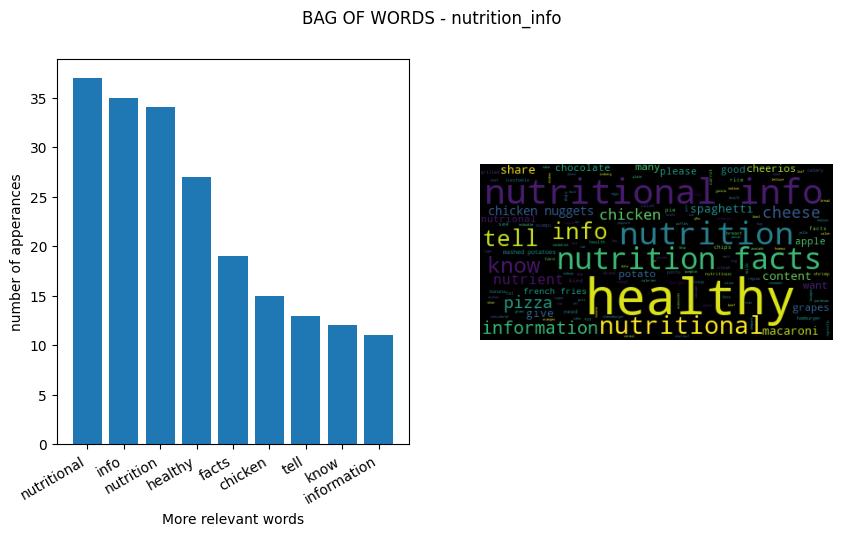

c:\Users\comas\venvpy3107\lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['doe', 'ha', 'wa'] not in stop_words.
  warnings.warn(


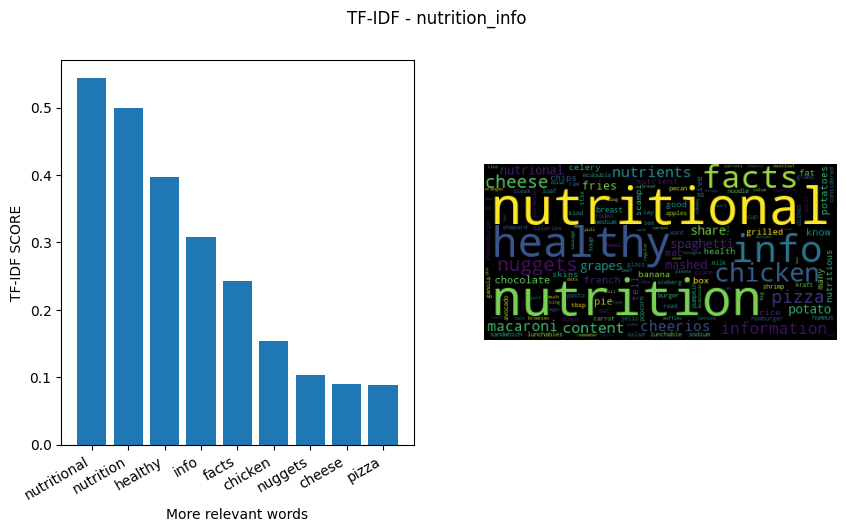

In [16]:
intents = train_val_df.groupby('intent')['query'].apply(lambda x: " ".join(x))
keys = list(intents.keys())
values = list(intents.values)

stop_words = stopwords.words('english')

for intent in ['alarm','nutrition_info']:
    
    n = 10

    plot_top_n(values, keys,intent, CountVectorizer(ngram_range=(1,1), preprocessor=preProcess, stop_words=stop_words), n)
    plot_top_n(values,keys, intent, TfidfVectorizer(ngram_range=(1,1), preprocessor=preProcess, stop_words=stop_words), n)


Using Bag-of-Words the most relevant words are the ones that appear more often in the intent class. Using instead TF-IDF the most relevant are the ones that appears often in the intent but that also they don't appear so often in all corpus. So, for example, we can see that *information* and *know* disappear from the most relevant words in the "*nutrition_info*" class using TF-IDF, probably because they're words that appear often in the intent class but they also appear very often in all corpus.

We can also notice that each intent can be distinguished very easily just taking into account a small portion of the query, the most relevant words. Indeed, there are words that have a much bigger TF-IDF score compared to the others. For example, in the *alarm* intent class the word "*alarm*" has much bigger score compared to the others tokens, and so it will be  classify straightforward as a query belonging to the *alarm* intent when seeing that word.

## BASELINE

As a baseline method we choose the Bag of Words for feature extraction because it is simple and yet powerful. The choosen classifier model was Naive Bayes because it is also simple and usually produces stable results.


In [18]:
def get_df(oos=False) :
    with open('data_full.json') as json_file: 
        data_dict = json.load(json_file) 

    train_data = data_dict['train']
    val_data = data_dict['val']
    test_data = data_dict['test']

    oos_train = data_dict['oos_train']
    oos_val = data_dict['oos_val']
    oos_test = data_dict['oos_test']


    train_df = pd.DataFrame(train_data, columns =['query', 'intent'])
    val_df = pd.DataFrame(val_data, columns =['query', 'intent'])
    test_df = pd.DataFrame(test_data, columns =['query', 'intent'])

    train_oos_df = pd.DataFrame(oos_train,columns=['query','intent'])
    val_oos_df = pd.DataFrame(oos_val,columns=['query','intent'])
    test_oos_df = pd.DataFrame(oos_test,columns=['query','intent'])

    if oos :
        # Concatenate dataframes to consider oos as a specific intent
        train_df = pd.concat([train_df,train_oos_df])
        val_df = pd.concat([val_df,val_oos_df])
        test_df = pd.concat([test_df,test_oos_df])
    
    train_df =pd.concat([train_df,val_df])
    
    return train_df, test_df

def predict_and_eval(df_test,x_test,model): 
    y_test = df_test['intent'].values
    y_pred = model.predict(x_test)

    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred, average="macro"))
    print("Recall:", recall_score(y_test, y_pred, average="macro"))
    print("F1:", f1_score(y_test, y_pred, average="macro"))


df_train, df_test = get_df(oos=False)

Extracting features using BOW . We consider only the top 1500 features oredered by term frequency across the corpus. The 1500 value is selected after some trials and leads to equivalent performances than using all features (around 5000). By doing so we are considering only the most relevant features to train our classifier and we discard the features that are not so useful for classification because they don't appear often in the corpus.

In [24]:
count_vectorizer = CountVectorizer(max_features=1500)
X_train_BOF = count_vectorizer.fit_transform(df_train['query']).toarray()
X_test_BOF = count_vectorizer.transform(df_test['query']).toarray()

print(X_train_BOF.shape)

(18000, 1500)


Training the Naive Bayes classifiers using the extracted features.

In [25]:
y_train = df_train['intent'].values
clf_log_int_BOF = MultinomialNB()
clf_log_int_BOF.fit(X_train_BOF, y_train)

MultinomialNB()

In [26]:
predict_and_eval(df_test,X_test_BOF,clf_log_int_BOF)

Accuracy: 0.8664444444444445
Precision: 0.8735420019043579
Recall: 0.8664444444444445
F1: 0.8645836103605846


We are quite satisfied with the results obtained by our baseline. But let's try to improve the performances using different features (TF-IDF and word embdeddings) and different classifiers

## USING TF-IDF



Here we just replace BOW with TF-IDF maintaining the same Naive Bayes classifier.

In [27]:
tfidf_vectorizer = TfidfVectorizer(max_features=1500)
X_train_TFIDF = tfidf_vectorizer.fit_transform(df_train['query']).toarray()
X_test_TFIDF = tfidf_vectorizer.transform(df_test['query']).toarray()

y_train = df_train['intent'].values
clf_log_int = MultinomialNB()
clf_log_int.fit(X_train_TFIDF, y_train)

predict_and_eval(df_test,X_test_TFIDF,clf_log_int)

Accuracy: 0.8906666666666667
Precision: 0.8952861839433804
Recall: 0.8906666666666668
F1: 0.8887997389878902


Using TF-IDF instead of BOW we see that performance gets better.

## WORD EMBEDDINGS 

After sparse representations we tried to use dense representation techniques using word embedding. We tried two different approach : the first one training our own word embeddings using the training set we had, and the second one using pre-trained word embeddings.

Here we use the Gaussian Naive Bayes classifier because the Multinomial one works only with discrete (and non negative) features. 

In [28]:
df_train, df_test = get_df(oos=False)

In the first step we pre-process our data. This step included only lemmatization and removing of special characters. Other pre-processing operations are not necessary because our dataset contains sentences already downcased and without punctuation.

In [7]:
def utils_preprocess_text(text):
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
                
    ## Lemmatisation 
    lem = nltk.stem.wordnet.WordNetLemmatizer()
    lst_text = [lem.lemmatize(word) for word in lst_text]

    ## removing special characters
    lst_text = [re.sub('[^a-zA-Z]', ' ', w) for w in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [30]:
# Apply preprocessing
df_train["query_clean"] = df_train["query"].apply(utils_preprocess_text)
df_test["query_clean"] = df_test["query"].apply(utils_preprocess_text)

### TRAINING WORD EMBEDDINGS


We use Word2Vec as model for training word embeddings and in particular we use the implementation given by the Gensim library.

To train our word embeddings using the train set we need to transform each row of the corpus into a list of unigrams. This is done by the function *corpus_as_lst(corpus)* .

In [31]:
def corpus_as_lst(corpus):
   ## create list of lists of unigrams
   lst_corpus = []
   for string in corpus:
      lst_words = string.split()
      lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, len(lst_words), 1)]
      lst_corpus.append(lst_grams)
   return lst_corpus

# Prepare the corpus to be trained by Word2Vec
train_corpus = corpus_as_lst(df_train['query_clean'])


Then we feed the Word2Vec model with the corpus transformed into a list of lists. We specify some parameters , in particular :
- *vector_size* is the size of each word embedding vector.
- *window* is the size of the window of words near the target word, that are implicitly considered as positive.
- *sg=1* indicates that we want to use skip-gram as training algorithm.
- *min_count=1* ignores all words with total frequency lower than 1.
- *epochs* is the number of iterations over the corpus

In [32]:
# Training word embeddings
wc_model = gensim.models.word2vec.Word2Vec(train_corpus, vector_size=300,   window=4, min_count=1, sg=1, epochs=30)

Now that we have the word embeddings, we want to transform each sentence into a word vector. This is done using the **text_to_mean(embeddings,text)** function which takes as inputs the word embeddings and a sentence. 

First of all it splits into tokens the sentence and for each token searches for the corresponding word vector. If the word is not present into the word embdeddings vocabulary it simply ignores it. 

At this point we have a NxM matrix where N is the number of words composing the sentence and M is the size of word vector (in our case 300). 

But we want to obtain only one vector for each sentence. So we simply take the mean along columns and we return the corresponding vector.

The function *get_word_embeddings(corpus)* simply computes the *text_to_mean* function for all sentences of the corpus.

In [33]:
def text_to_mean_vector(embeddings, text):
    tokens = text.split()
    vec = []
    for i in range(len(tokens)):
        try:
            vec.append(embeddings.get_vector(tokens[i]))
        except KeyError:
            True   # simply ignore out-of-vocabulary tokens
    if(len(vec)!=0):
        return [sum([row[j] for row in vec]) / len(vec) for j in range(len(vec[0]))]
    else : 
        return []  # if every token of the sentence is out-of-vocabulary we simply return an empty list

def get_word_embdeddings(corpus, model):
    embeddings_corpus = []
    for c in corpus:
        mean_vec = text_to_mean_vector(model, c)
        if(len(mean_vec)!=0):
            embeddings_corpus.append(mean_vec)
        else:
            # if every token of the sentence is out-of-vocabulary we represents that sentence as a list of zeros
            embeddings_corpus.append(np.zeros(model.vector_size,))
    return np.array(embeddings_corpus)


In [34]:
# Extracting word embeddings
X_train = get_word_embdeddings(df_train['query_clean'], wc_model.wv)
X_test = get_word_embdeddings(df_test['query_clean'], wc_model.wv)

print(X_train.shape)
print(X_test.shape)


(18000, 300)
(4500, 300)


In [35]:

def train_model(model,X_train,df_train,df_test):
    
    # Getting labels
    y_train = df_train['intent'].values
    y_test = df_test['intent'].values
        
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    return y_pred,y_test

# Training 
nb = GaussianNB()
y_pred,y_test=train_model(nb,X_train,df_train,df_test)

# Evaluating
predict_and_eval(df_test,X_test,nb)

Accuracy: 0.8046666666666666
Precision: 0.826309800856468
Recall: 0.8046666666666666
F1: 0.8079923524517681


### USING PRE-TRAINED WORD EMBEDDINGS

Instead of training our word embeddings we can also use pre-trained word embeddings. We use **word2vec-google-news-300** pre-trained vectors which are trained on a part of the Google News dataset (about 100 billion words). The model contains 300-dimensional vectors for 3 million words and phrases.

In [20]:
'''
To download the pre-trained word embdeddings

import gensim.downloader

google_300 = gensim.downloader.load('word2vec-google-news-300')

'''

# we load pretrained word embeddings
google_300 = gensim.models.KeyedVectors.load("./models/google_300")

In [21]:
# Extracting word embeddings
X_train = get_word_embdeddings(df_train['query_clean'], google_300)
X_test = get_word_embdeddings(df_test['query_clean'], google_300)

print(X_train.shape)
print(X_test.shape)


# Training 
nb = GaussianNB()
y_pred,y_test=train_model(nb,X_train,df_train,df_test)

# Evaluating
predict_and_eval(df_test,X_test,nb)

(18000, 300)
(4500, 300)
Accuracy: 0.784
Precision: 0.8182462826107042
Recall: 0.7839999999999999
F1: 0.7926914725433356


We notice that the performance using pre-trained word embeddings are worse than using the ones trained by us. This probably happens because we train our word embeddings using the train set which is similar to the test set in the sentences' structure. The pre-trained ones instead are trained on a corpus, even if bigger, that is slightly different.

It's interesting to notice also that we obtain worst results using word embdedding as features rather than sparse represenations (BOW or TF-IDF). This probably happens because the sentences that we want to classify are very short and not so articulated, so they're more represented by individual words than by relations between words in the same sentence. 

## TRYING DIFFERENT CLASSIFIERS
Now we'll try to use different classifiers to see the difference of performances between them. We'll use sparse representations for features because they lead to better results.

We'll also analyze how out-of-scope queries affect the performance.

In [36]:
df_train, df_test = get_df(oos=False)

We evaluate the following classifiers

In [37]:
models = [
    LogisticRegression(multi_class='multinomial', max_iter=300),
    SVC(probability=True),
    DecisionTreeClassifier(random_state=0),
    RandomForestClassifier(max_depth=2, random_state=0),
    GaussianNB()
]
model_names = [
    "   Logistic Regression",
    "Support Vector Machine",
    "         Decision Tree",
    "         Random Forest",
    "  Gaussian Naive Bayes"
]

In [9]:
def train_model(model, X_train, df_train, df_test):
    y_train = df_train['intent'].values
    start_time = time.time()
    model = model.fit(X_train, y_train)
    print("%s seconds"% (time.time() - start_time))
    return model

def predic_of_model(model_fited, X_test):
    y_test = df_test['intent'].values
    y_pred = model_fited.predict(X_test)
   
    return y_pred, y_test, X_test

#### Fit chosen classifiers

In [39]:
for model, name in zip(models, model_names):
    train_model(model, X_train_TFIDF, df_train, df_test)
    print("finished train model: ", name)

30.647072553634644 seconds
finished train model:     Logistic Regression
2002.4396727085114 seconds
finished train model:  Support Vector Machine
66.32986831665039 seconds
finished train model:           Decision Tree
2.4394171237945557 seconds
finished train model:           Random Forest
0.5484752655029297 seconds
finished train model:    Gaussian Naive Bayes


### Report the classifiers results


In [10]:
def printReport(model, name, X_test, y_test, y_pred, all_classes =False):
    print("################# " + name.upper() + ' #################')
    # score
    print(name + ": {:.4f}%".format(model.score(X_test, y_test) * 100))
    # confusion matrix
    print(confusion_matrix(y_test, y_pred))
    # report
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred, average="macro"))
    print("Recall:", recall_score(y_test, y_pred, average="macro"))
    print("F1:", f1_score(y_test, y_pred, average="macro"))
    if all_classes:
        print(classification_report(y_test, y_pred))

Print the report and confusion matrix of each chosen model

In [43]:
for fited_model, name in zip(models, model_names):
    y_pred, y_test, X_test = predic_of_model(fited_model, X_test_TFIDF)
    printReport(fited_model, name, X_test, y_test, y_pred)
    

#################    LOGISTIC REGRESSION#################
   Logistic Regression: 89.9111%
[[26  0  0 ...  0  0  0]
 [ 0 30  0 ...  0  0  0]
 [ 0  0 29 ...  0  0  0]
 ...
 [ 0  0  0 ... 20  4  0]
 [ 0  0  0 ...  0 28  0]
 [ 0  0  0 ...  0  0 17]]
Accuracy: 0.8991111111111111
Precision: 0.9040563482158193
Recall: 0.8991111111111112
F1: 0.8986386859712802
################# SUPPORT VECTOR MACHINE#################
Support Vector Machine: 91.2444%
[[27  0  0 ...  0  0  0]
 [ 0 28  0 ...  0  0  0]
 [ 0  0 29 ...  0  0  0]
 ...
 [ 0  0  0 ... 22  4  0]
 [ 0  0  0 ...  0 29  0]
 [ 0  0  0 ...  0  0 17]]
Accuracy: 0.9124444444444444
Precision: 0.9193206289161385
Recall: 0.9124444444444445
F1: 0.9124228878190179
#################          DECISION TREE#################
         Decision Tree: 78.3111%
[[25  0  0 ...  0  0  0]
 [ 0 20  0 ...  0  0  0]
 [ 0  0 28 ...  0  0  0]
 ...
 [ 0  0  0 ... 16  5  0]
 [ 0  0  0 ...  1 16  0]
 [ 0  0  0 ...  0  0 14]]
Accuracy: 0.7831111111111111
Precision: 0

c:\Users\comas\venvpy3107\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#################   GAUSSIAN NAIVE BAYES#################
  Gaussian Naive Bayes: 73.2444%
[[18  0  0 ...  0  0  0]
 [ 0 20  0 ...  0  0  0]
 [ 0  0 24 ...  1  0  0]
 ...
 [ 0  0  0 ... 19  1  0]
 [ 0  0  0 ...  0 27  0]
 [ 0  0  0 ...  0  0  8]]
Accuracy: 0.7324444444444445
Precision: 0.7414921162768965
Recall: 0.7324444444444445
F1: 0.7246255985247143


Support Vector Machine is the model obtaining the best results.

## CONSIDERING OOS QUERIES

Now we evaluate how the OOS samples affect the performance of the model. We'll use SVM which is the best performing model.

We consider the OOS as a new intent, obtaining a dataset with 151 intents. In this way the dataset remains very balanced because for each intent (including OOS) we have 120 (100 train + 20 val ) queries for training and 30 for testing. If we had decided to make a binary classification, between in-scope and out-of-scope intents, we would have a very unbalanced dataset.Having 22,500 in-scope queries and 1,200 oos queries.

In [11]:
# Considering also oos 
df_train, df_test = get_df(oos=True)

# Extract features now considering also OOS samples
tfidf_vectorizer = TfidfVectorizer(max_features=1500)
X_train_TFIDF = tfidf_vectorizer.fit_transform(df_train['query']).toarray()
X_test_TFIDF = tfidf_vectorizer.transform(df_test['query']).toarray()

# Training the model
model = SVC(probability=True)

train_model(model, X_train_TFIDF, df_train, df_test)


36.64818000793457 seconds


LogisticRegression(max_iter=300, multi_class='multinomial')

In [12]:

# Predictions
y_pred, y_test, X_test = predic_of_model(model,X_test_TFIDF )

# Report
printReport(model, 'Support Vector Machine', X_test, y_test, y_pred, all_classes=True)

################# SUPPORT VECTOR MACHINE #################
Support Vector Machine: 79.1273%
[[26  0  0 ...  0  0  0]
 [ 0 30  0 ...  0  0  0]
 [ 0  0 29 ...  0  0  0]
 ...
 [ 0  0  0 ... 20  4  0]
 [ 0  0  0 ...  0 28  0]
 [ 0  0  0 ...  0  0 17]]
Accuracy: 0.7912727272727272
Precision: 0.8069245814890172
Recall: 0.8930419426048565
F1: 0.8409361081263511
                           precision    recall  f1-score   support

      accept_reservations       0.96      0.87      0.91        30
          account_blocked       0.79      1.00      0.88        30
                    alarm       0.91      0.97      0.94        30
       application_status       0.97      1.00      0.98        30
                      apr       0.94      1.00      0.97        30
            are_you_a_bot       0.86      1.00      0.92        30
                  balance       0.97      0.93      0.95        30
             bill_balance       0.67      0.87      0.75        30
                 bill_due       0.79   

As expected the results using also OOS samples are worse, because the model got confused by the oos queries and tends to classify them in one of the intent classes. Indeed the oos queries don't have particular features (frequent words for example) that can help the model to classify them as oos, but they tend to be similar to in-scope queries.

## Error analysis
After training and evaluating our intent classification model, we performed a manual error analysis to identify patterns in the misclassified queries. We started by looking at the confusion matrix for our model's predictions and found that some intents were consistently being confused with the out-of-scope class. 

***Note: Since the SVM, model with the best score, takes a considerable time for trainnig in the error analysis we are using Logistic Regression. The model with the second best results and shorter run time.***

### Calculate the percentage of missclassifications

In [111]:
def compare_misclassification(labels, class1, class2, y_test, y_pred):
    # Get the indices of the two classes
    class1_idx = labels.index(class1)
    class2_idx = labels.index(class2)

    # Generate a confusion matrix with label indices
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # Get the total number of samples 
    class1_queries = sum(conf_matrix[class1_idx])

    # Get the number of misclassifications 
    misclassifications_class1 = conf_matrix[class1_idx][class2_idx] 
    
    # Calculate the percentage of misclassifications 
    percent_misclassified = (misclassifications_class1 / class1_queries) * 100

    return percent_misclassified

In [112]:
# Not Considering the oos 
df_train, df_test = get_df(oos= False)

# Extract features now considering also OOS samples
tfidf_vectorizer = TfidfVectorizer(max_features=1500)
X_train_TFIDF = tfidf_vectorizer.fit_transform(df_train['query']).toarray()
X_test_TFIDF = tfidf_vectorizer.transform(df_test['query']).toarray()

# Training the model
model = LogisticRegression(multi_class='multinomial', max_iter=300)

train_model(model, X_train_TFIDF, df_train, df_test)

# Predictions
y_pred, y_test, X_test = predic_of_model(model,X_test_TFIDF )

109.55059885978699 seconds


In [113]:
printReport(model, 'Logistic Regression', X_test, y_test, y_pred, all_classes=True)

################# LOGISTIC REGRESSION #################
Logistic Regression: 89.9111%
[[26  0  0 ...  0  0  0]
 [ 0 30  0 ...  0  0  0]
 [ 0  0 29 ...  0  0  0]
 ...
 [ 0  0  0 ... 20  4  0]
 [ 0  0  0 ...  0 28  0]
 [ 0  0  0 ...  0  0 17]]
Accuracy: 0.8991111111111111
Precision: 0.9040563482158193
Recall: 0.8991111111111112
F1: 0.8986386859712802
                           precision    recall  f1-score   support

      accept_reservations       0.96      0.87      0.91        30
          account_blocked       0.88      1.00      0.94        30
                    alarm       0.94      0.97      0.95        30
       application_status       1.00      1.00      1.00        30
                      apr       0.97      1.00      0.98        30
            are_you_a_bot       0.88      1.00      0.94        30
                  balance       1.00      0.93      0.97        30
             bill_balance       0.90      0.87      0.88        30
                 bill_due       0.81      0.8

As we can see that there are several other classes with relatively high misclassification rates for "similar" intent queries, such as 'calendar_update' and 'calendar', with 30.0% of the 'calendar_update' queries misclassified as'calendar'. 

Furthermore, we can see that the 'rewards_balance' class also has a relatively high misclassification rate for 'redeem_rewards' queries at 20.0%. This suggests that there may be some similarities or confusion between this classes.

Since there are several classes with a high missiclassification, in the future it may be useful to investigate these specific cases further, identify patterns or commonalities among this classes in order to improve the robustness of the model for these intents in particular. These results suggest that probably the model has some issues to distinguish context similar classes. What is consistent, since this similar classes does not have distinguishable "keys words" between them.

**Note: this block takes long run time, complexity N^2.**

In [114]:
labels = list(set(y_test))
sorted_labels = sorted(labels) 
for class_1 in sorted_labels:
    for class_2 in sorted_labels:
        if( class_1 != class_2):
            percent_misclassified = compare_misclassification(sorted_labels, class_1, class_2, y_test, y_pred)
            if percent_misclassified > 10.0:
                print(f"Percentage of '"+ class_1 + "' queries misclassified as'" + class_2 + "': {:.2f}%".format(percent_misclassified))


Percentage of 'calendar' queries misclassified as'calendar_update': 30.00%
Percentage of 'change_ai_name' queries misclassified as'make_call': 16.67%
Percentage of 'current_location' queries misclassified as'share_location': 16.67%
Percentage of 'food_last' queries misclassified as'expiration_date': 13.33%
Percentage of 'improve_credit_score' queries misclassified as'credit_score': 13.33%
Percentage of 'meal_suggestion' queries misclassified as'restaurant_suggestion': 13.33%
Percentage of 'no' queries misclassified as'yes': 16.67%
Percentage of 'pin_change' queries misclassified as'change_ai_name': 16.67%
Percentage of 'redeem_rewards' queries misclassified as'rewards_balance': 20.00%
Percentage of 'shopping_list' queries misclassified as'order': 16.67%
Percentage of 'shopping_list' queries misclassified as'todo_list': 13.33%
Percentage of 'todo_list' queries misclassified as'todo_list_update': 13.33%
Percentage of 'todo_list_update' queries misclassified as'shopping_list_update': 13.3

### How the out of scope class affects the predictions
 We can see that there are several classes that have a relatively high percentage of misclassifications as the 'oss' class. For example, the 'travel_suggestion' class has a misclassification rate of 66.7% as 'oss', while the 'w2' class has a misclassification rate of 40.0% as 'oss'. This suggests that there is some overlap and confusion between these classes and the 'oss' class. This results suggest something that we were already expecting, that it is the out-of-scope class causes some overlape over other intents.

In [116]:
#Considering also oos 
df_train, df_test = get_df(oos=True)

# Extract features now considering also OOS samples
tfidf_vectorizer = TfidfVectorizer(max_features=1500)
X_train_TFIDF = tfidf_vectorizer.fit_transform(df_train['query']).toarray()
X_test_TFIDF = tfidf_vectorizer.transform(df_test['query']).toarray()

# Training the model
model = LogisticRegression(multi_class='multinomial', max_iter=300)

train_model(model, X_train_TFIDF, df_train, df_test)

# Predictions
y_pred, y_test, X_test = predic_of_model(model,X_test_TFIDF)

32.87961506843567 seconds


In [117]:
printReport(model, 'Logistic Regression', X_test, y_test, y_pred, all_classes=True)

################# LOGISTIC REGRESSION #################
Logistic Regression: 79.1273%
[[26  0  0 ...  0  0  0]
 [ 0 30  0 ...  0  0  0]
 [ 0  0 29 ...  0  0  0]
 ...
 [ 0  0  0 ... 20  4  0]
 [ 0  0  0 ...  0 28  0]
 [ 0  0  0 ...  0  0 17]]
Accuracy: 0.7912727272727272
Precision: 0.8069245814890172
Recall: 0.8930419426048565
F1: 0.8409361081263511
                           precision    recall  f1-score   support

      accept_reservations       0.96      0.87      0.91        30
          account_blocked       0.79      1.00      0.88        30
                    alarm       0.91      0.97      0.94        30
       application_status       0.97      1.00      0.98        30
                      apr       0.94      1.00      0.97        30
            are_you_a_bot       0.86      1.00      0.92        30
                  balance       0.97      0.93      0.95        30
             bill_balance       0.67      0.87      0.75        30
                 bill_due       0.79      0.8

In [118]:
labels = sorted(list(set(y_test)))
for label in labels:
    percent_misclassified = compare_misclassification(labels, label, 'oos', y_test, y_pred)
    if percent_misclassified > 0:
        print(f"Percentage of '"+ label + "' queries misclassified as 'oss': {:.2f}%".format(percent_misclassified))

Percentage of 'bill_balance' queries misclassified as 'oss': 3.33%
Percentage of 'bill_due' queries misclassified as 'oss': 3.33%
Percentage of 'calculator' queries misclassified as 'oss': 6.67%
Percentage of 'calendar_update' queries misclassified as 'oss': 6.67%
Percentage of 'cancel' queries misclassified as 'oss': 3.33%
Percentage of 'carry_on' queries misclassified as 'oss': 6.67%
Percentage of 'change_ai_name' queries misclassified as 'oss': 3.33%
Percentage of 'cook_time' queries misclassified as 'oss': 3.33%
Percentage of 'definition' queries misclassified as 'oss': 3.33%
Percentage of 'distance' queries misclassified as 'oss': 6.67%
Percentage of 'food_last' queries misclassified as 'oss': 3.33%
Percentage of 'goodbye' queries misclassified as 'oss': 3.33%
Percentage of 'greeting' queries misclassified as 'oss': 3.33%
Percentage of 'how_busy' queries misclassified as 'oss': 10.00%
Percentage of 'income' queries misclassified as 'oss': 3.33%
Percentage of 'international_visa' q

However, as show below the out of scope class is not frequently misclassificate as other intents. Suggesting that the out-of-scope classes does not have distinguishable "keys words" iqual to the other classes.

Overall, these results suggest that there may be some limitations to the current model's performance on identifying intente queries and distinguishing them from out-of-scope. It may be worth investigating further to see if any adjustments can be made to improve its performance on these samples. Additionally, it may be useful to explore alternative techniques in order to improve classification accuracy.


In [119]:
for label in labels:
    percent_misclassified = compare_misclassification(labels,'oos', label, y_test, y_pred)
    if percent_misclassified > 0:
        print(f"Percentage of 'oss' queries misclassified as '"+ label + "': {:.2f}%".format(percent_misclassified))

Percentage of 'oss' queries misclassified as 'account_blocked': 0.40%
Percentage of 'oss' queries misclassified as 'alarm': 0.10%
Percentage of 'oss' queries misclassified as 'application_status': 0.10%
Percentage of 'oss' queries misclassified as 'apr': 0.10%
Percentage of 'oss' queries misclassified as 'are_you_a_bot': 0.20%
Percentage of 'oss' queries misclassified as 'balance': 0.10%
Percentage of 'oss' queries misclassified as 'bill_balance': 1.00%
Percentage of 'oss' queries misclassified as 'bill_due': 0.30%
Percentage of 'oss' queries misclassified as 'book_flight': 0.60%
Percentage of 'oss' queries misclassified as 'book_hotel': 0.70%
Percentage of 'oss' queries misclassified as 'calculator': 1.50%
Percentage of 'oss' queries misclassified as 'calendar': 0.70%
Percentage of 'oss' queries misclassified as 'calories': 0.20%
Percentage of 'oss' queries misclassified as 'cancel': 0.60%
Percentage of 'oss' queries misclassified as 'cancel_reservation': 0.10%
Percentage of 'oss' que

Percentage of 'oss' queries misclassified as 'who_made_you': 2.00%
Percentage of 'oss' queries misclassified as 'yes': 0.20%


## Comparison with existing work
In the study conducted in the article on which our assignment is based on, they deal with the out scope class in three different ways:

1. **oos-train**, where they train an additional (i.e. 151st) intent on out-of-scope training data.
2. **oos- threshold**, where they use a threshold on the classifier's probability estimate. 
3. **oos-binary**, a two-stage process where they first classify a query as in- or out-of-scope, then classify it into one of the 150 intents if classified as in-scope.

The approach selected by us was the oos-train. They used recall to evaluate out-of-scope since for the purpose of the article they were more interested in cases where oos are predicted as in-scope, as this would mean that the system would give the user a response that is completely wrong and out of context. 
The recall obtained by the SVM in their study was **14.5%** (They had better results with deep learning models, but since the purpose of this assignment was use "traditional" ML this is the closest comparison that could be made). We obtained  a precision of about **80.4%**, emphasizing the importance of pre-processing, feature extraction and other NLP tools specially when not using deep learning models.

## Conclusions

Overall, We think that our exploration on the ask had good results and  we accomplished the proposed work for the assignment. Those are some highlights that we conclude during project's execution:

 - The results showed that all of the models performed well on in-scope intent classification, with F1 scores ranging from 0.89 to 0.91. However, the models struggled with identifying out-of-scope queries.
 
 - In terms of specific model performance, the analysis showed that the Support Vector Machine (SVM) model with space representation provided the best overall performance for both in-scope and out-of-scope prediction.
 
 - The self-trained word embeddings may performed better than pre-trained word embeddings, one reason is that pre-trained embeddings are trained on large, general-purpose corpora and may had not captured the nuances of our queries in the dataset. In contrast,  the self-trained embeddings were trained on more focused corpus that is more closely aligned with the target task.
 
 - Sparse representations provided a better performance than word embeddings for intent classification and out-of-scope prediction. One reason for this is that sparse representations are based on word frequency and distinguishability. This approach allows for a more nuanced representation of the queries.

